In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython import display
from pvrecorder import PvRecorder
import requests
import ipywidgets as widgets

from helper_functions import plot_loss_curves, squeeze, add_white_noise, get_spectrogram, get_spectrogram_and_label
from plotting import plot_spectrogram, plot_wave_spectrogram_and_audio
from models import create_model_1, create_model_2, create_model_3
plt.style.use("grovbox")

2024-10-13 19:58:57.040094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 19:58:57.218005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 19:58:57.272740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 19:58:57.528985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 19:59:00.304171: W tensorflow/compiler/tf2

In [2]:
DATASET_PATH = "data/mini_speech_commands"

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        "mini_speech_commands.zip",
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir=".", cache_subdir="data"
    )


In [3]:
train_ds, valid_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # maximum length of an audio sequence.audio files longer than this will be truncated to output_sequence_length 
    subset="both")                 # use "both" only if validation split is set

label_names = np.array(train_ds.class_names)
print("label names: ", label_names); print(train_ds.element_spec)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names:  ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [4]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
valid_ds = valid_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = valid_ds.shard(num_shards=2, index=0)
valid_ds = valid_ds.shard(num_shards=2, index=1)

white_train_ds = train_ds.map(add_white_noise, tf.data.AUTOTUNE)
white_valid_ds = valid_ds.map(add_white_noise, tf.data.AUTOTUNE)

In [5]:
for example_audio, example_label in train_ds.take(1):
    print(example_audio.shape)
    print(example_label.shape)

for example_white_audio, example_white_label in white_train_ds.take(1):
    print(example_audio.shape)
    print(example_label.shape)

(64, 16000)
(64,)
(64, 16000)
(64,)


2024-10-13 19:59:03.347397: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-13 19:59:03.561709: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


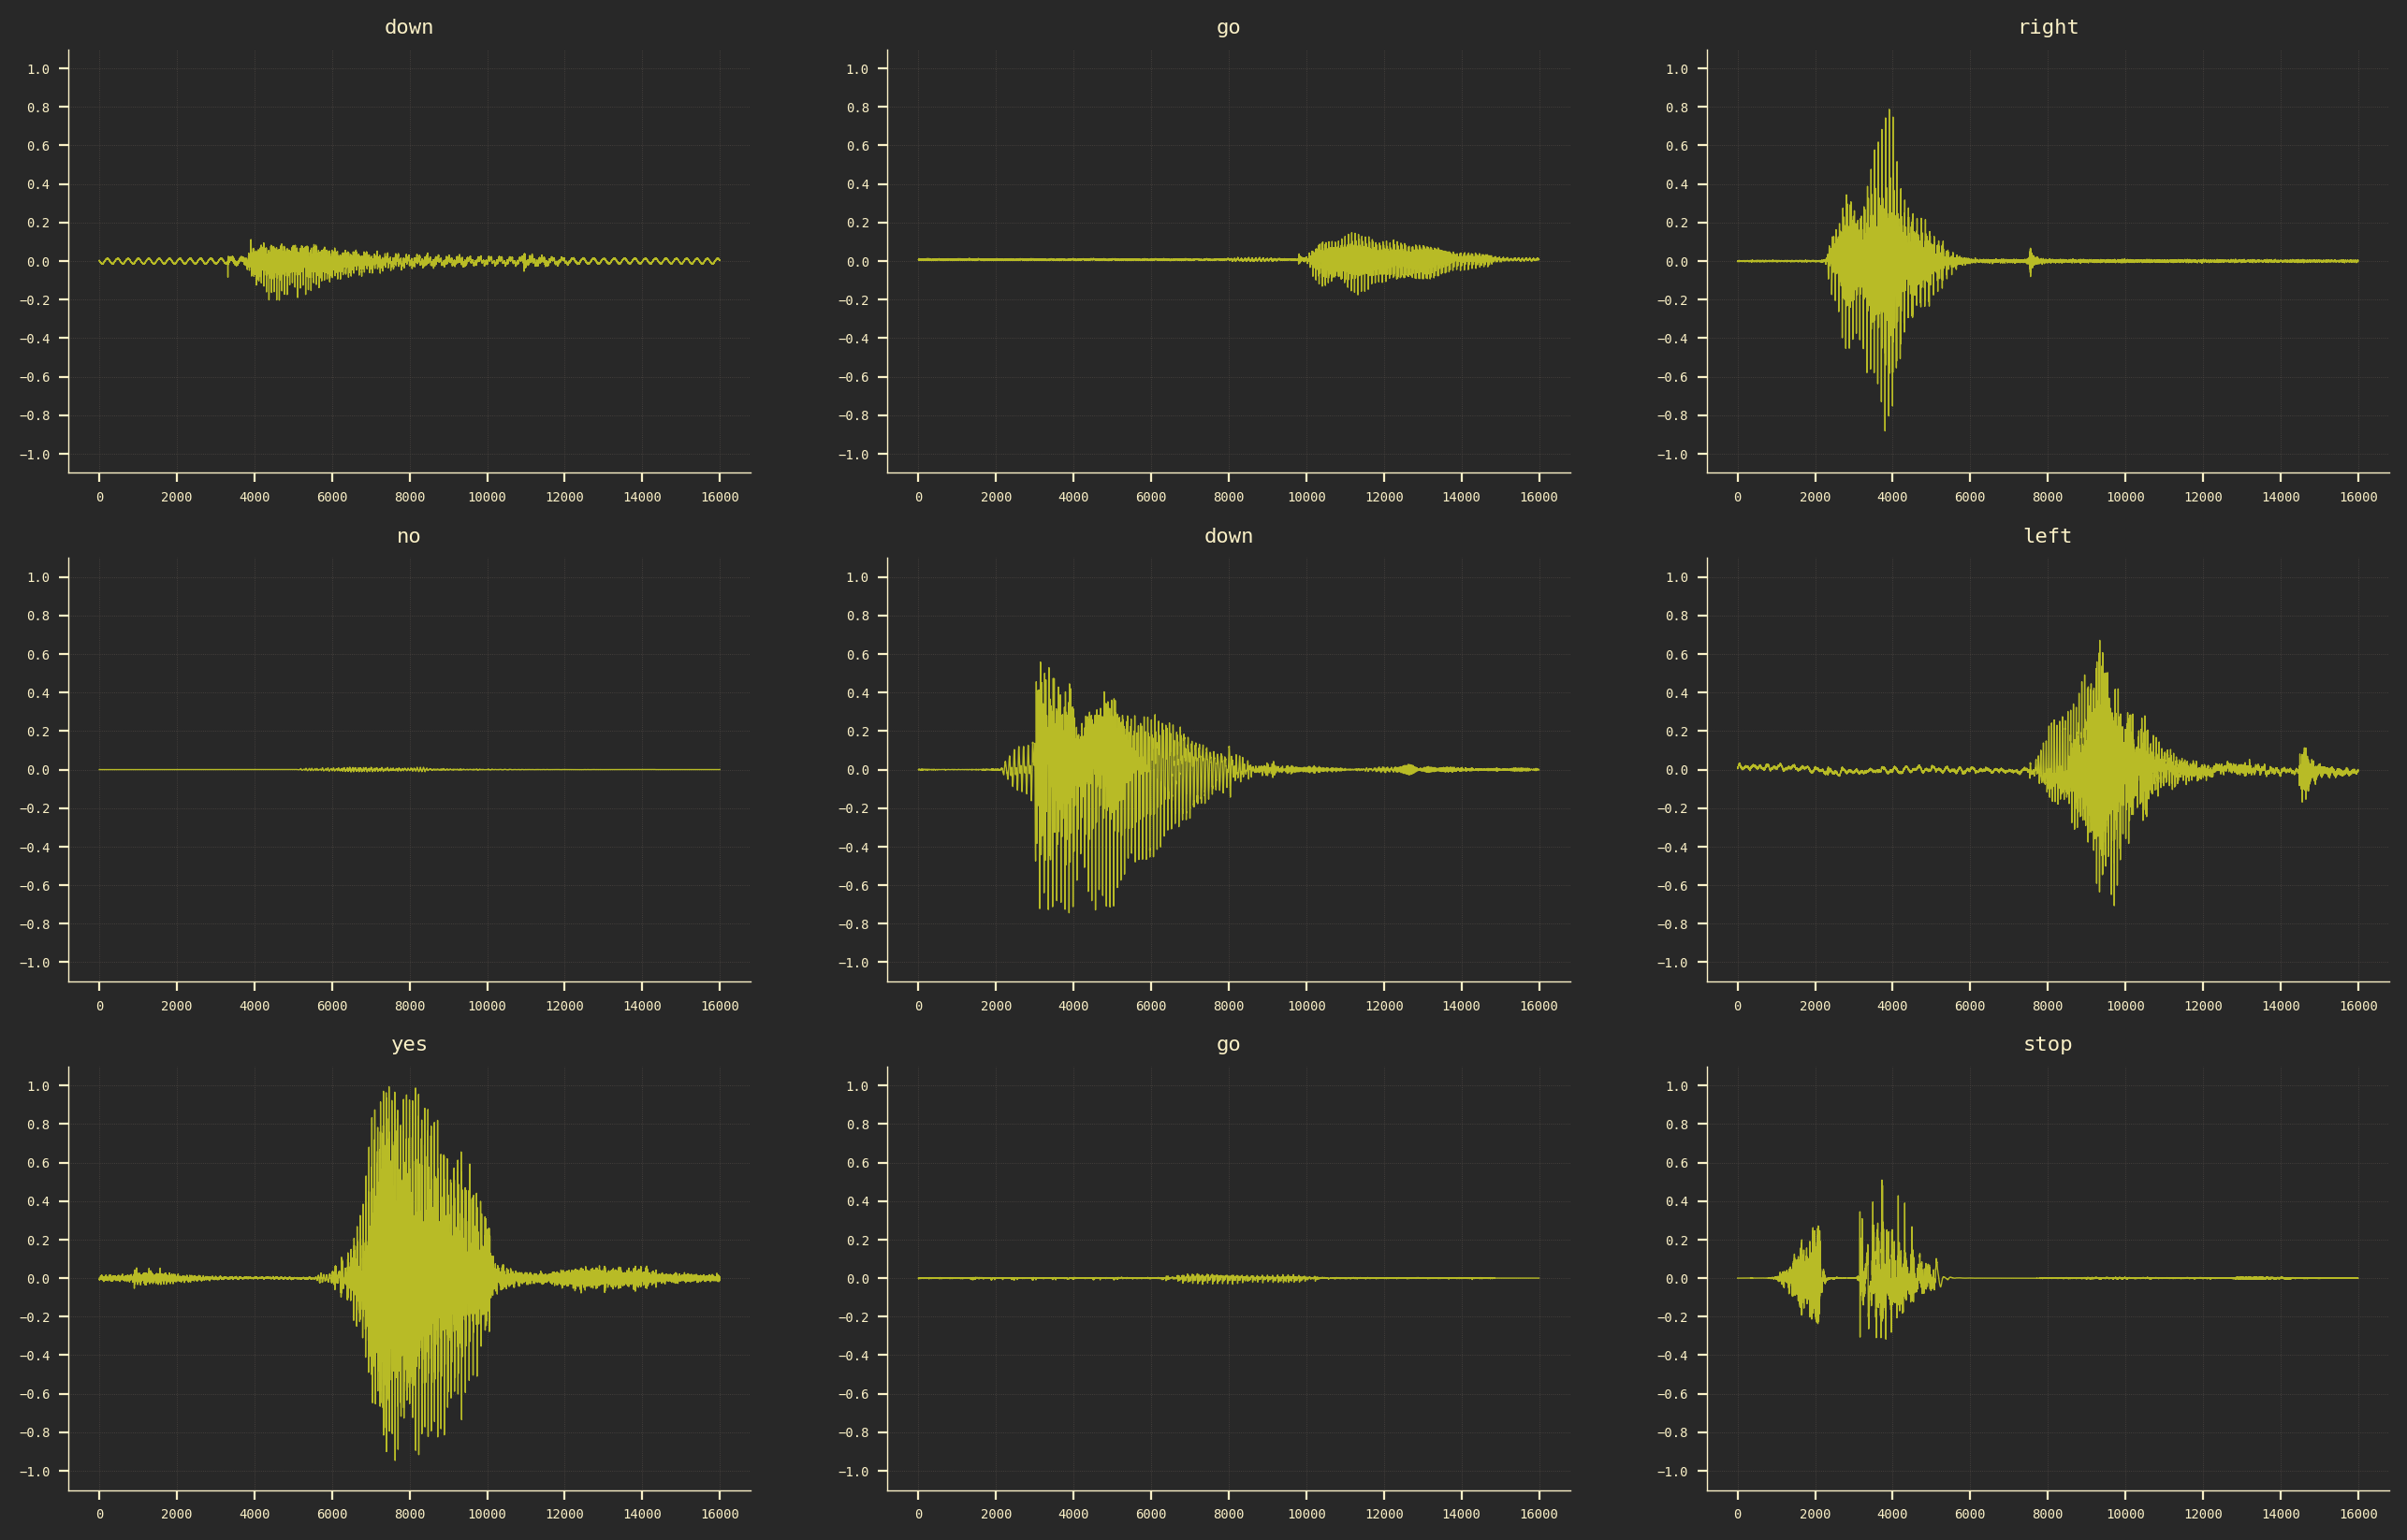

In [6]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_label[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

Label:  down
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


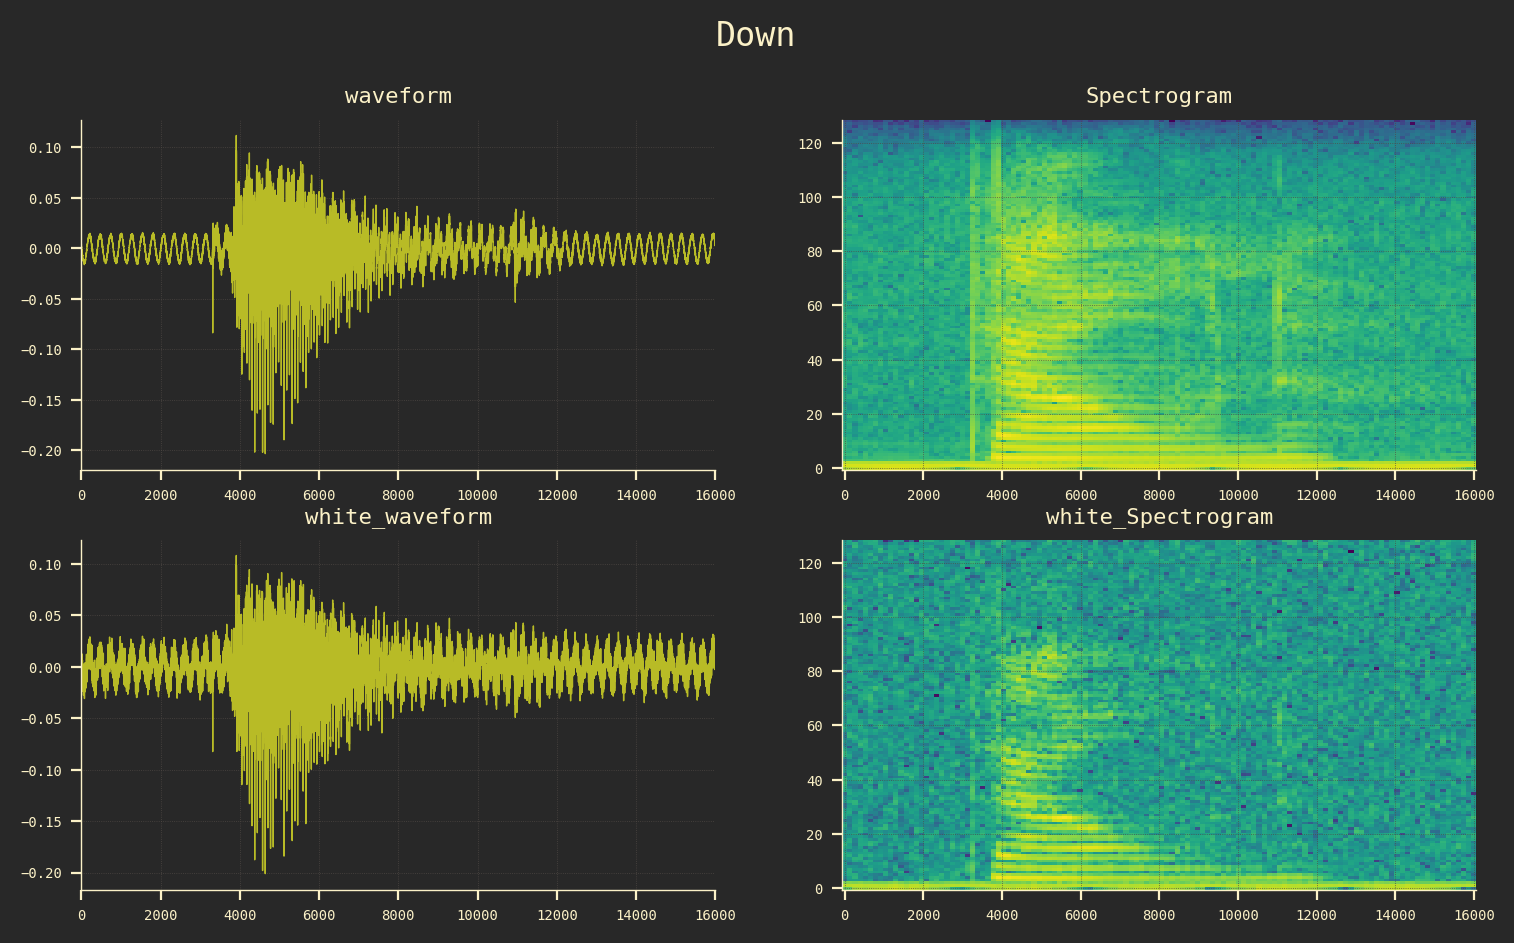

Label:  go
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


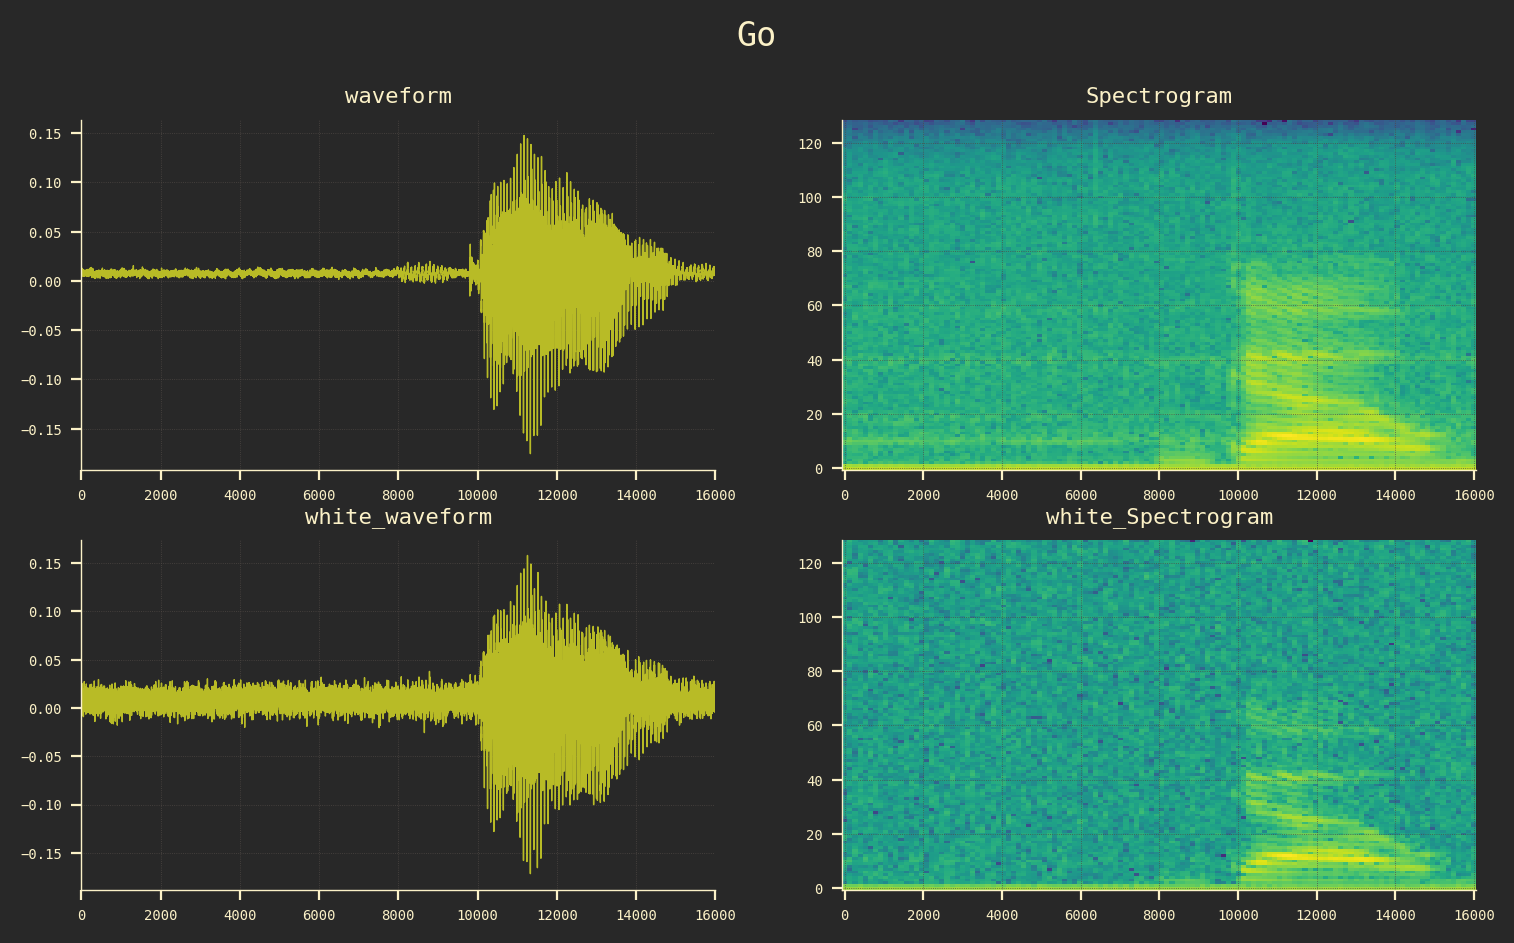

Label:  right
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


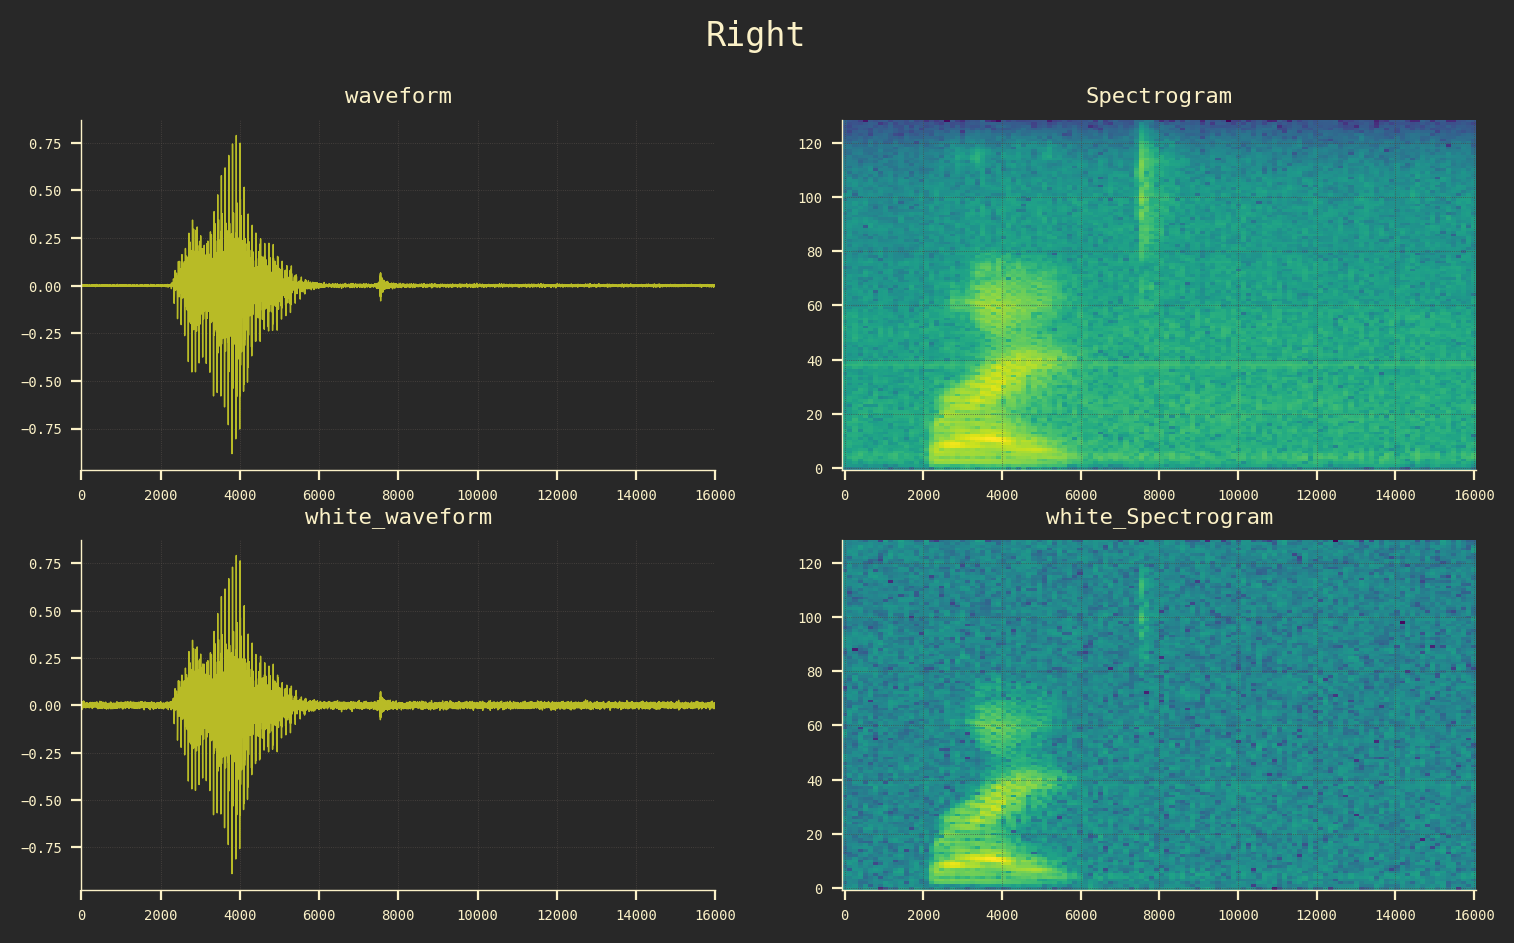

In [7]:
plot_wave_spectrogram_and_audio(3, example_audio, example_label, label_names)

In [8]:
train_spectrogram_ds = white_train_ds.map(get_spectrogram_and_label, tf.data.AUTOTUNE)
valid_spectrogram_ds = white_valid_ds.map(get_spectrogram_and_label, tf.data.AUTOTUNE)
test_spectrogram_ds = test_ds.map(get_spectrogram_and_label, tf.data.AUTOTUNE)

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

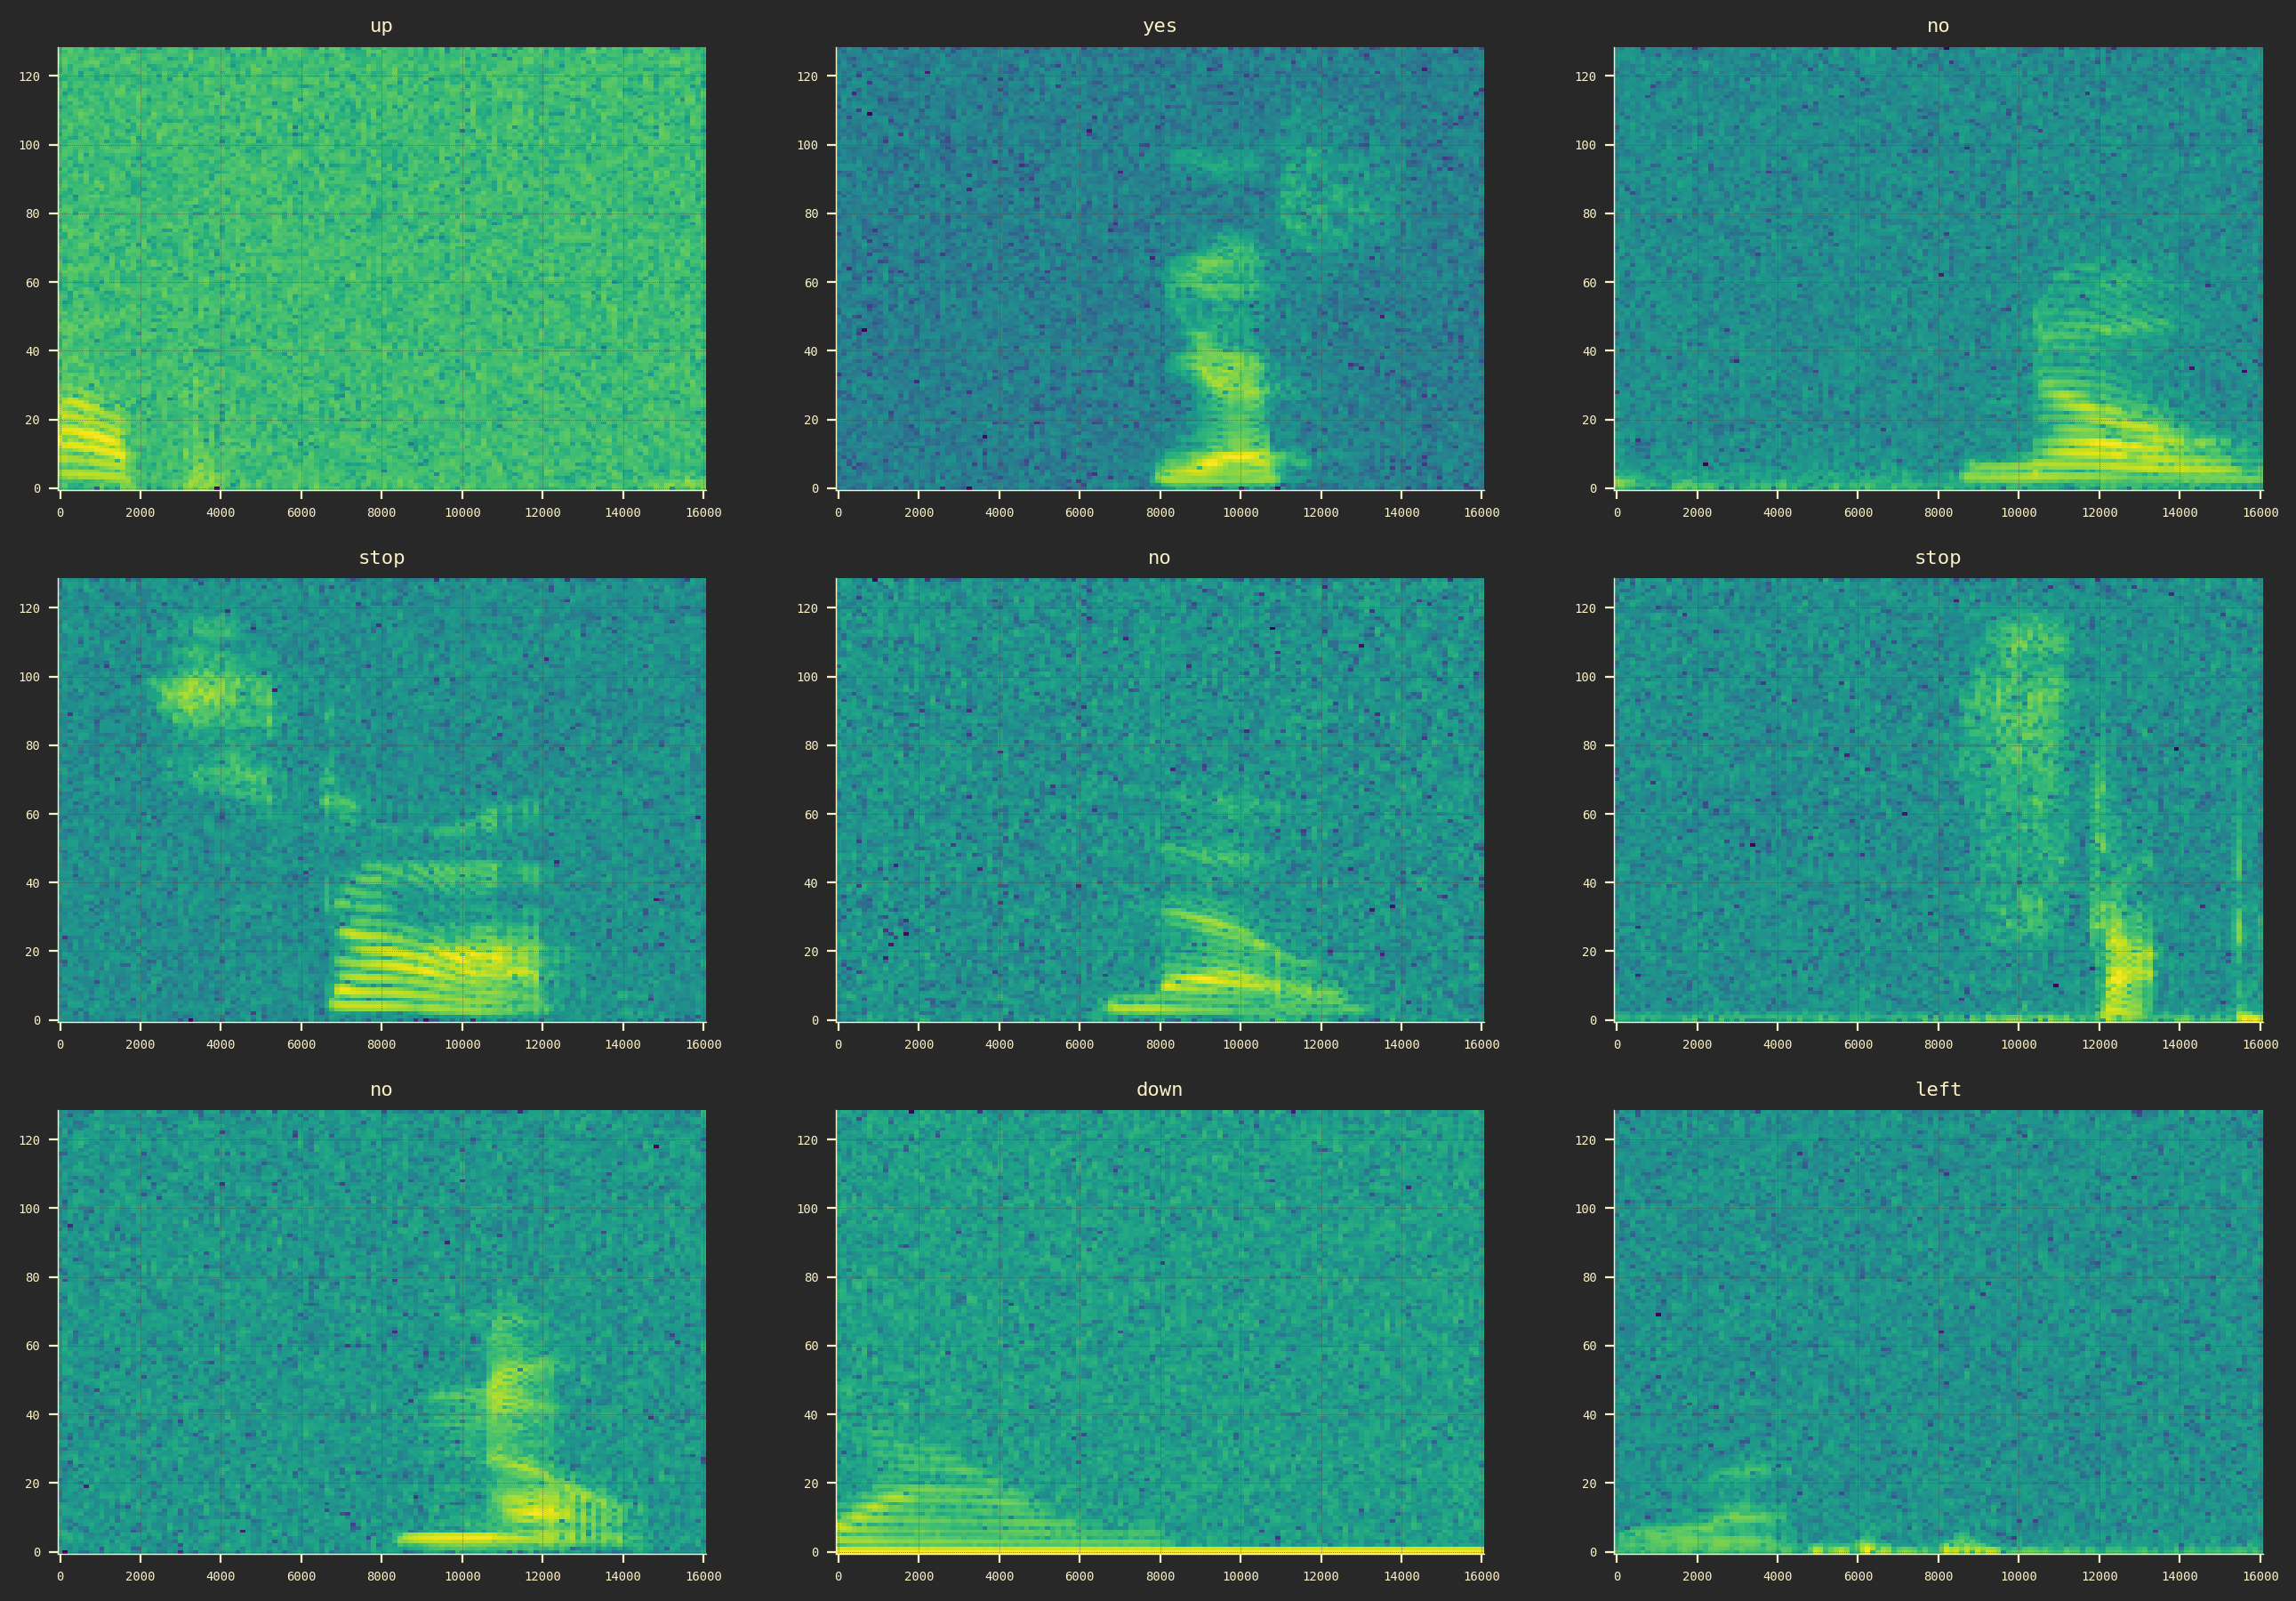

In [10]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 11))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [11]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = valid_spectrogram_ds.prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
input_shape = example_spectrograms.shape[1:] ; print(input_shape)
num_labels = len(label_names)

#Instantiate the 'tf.keras.layers.Normalization' layer
norm_layer = tf.keras.layers.Normalization()
# fit the state of the layer to the spectrograms
# with 'normalization.adapt'
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

(124, 129, 1)


2024-10-13 19:59:27.901832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:29: Filling up shuffle buffer (this may take a while): 60 of 1000
2024-10-13 19:59:31.658433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [13]:
if not os.path.exists("checkpoint"):
    os.mkdir("checkpoint")
    model = create_model_1()
    EPOCHS = 25
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=EPOCHS,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
    )
    model.save_weights("checkpoint/last_weights_1.weights.h5")
    model.save("checkpoint/model_1.keras")
    plot_loss_curves(history, (16, 5))
else:
    model = tf.keras.models.load_model("checkpoint/model_1.keras")

In [14]:
input_shape = example_audio.shape[1:] ; print(input_shape)
num_labels = len(label_names) ; print(num_labels)

(16000,)
8


In [15]:
if not os.path.exists("checkpoint1"):
    os.mkdir("checkpoint1")
    model_1 = create_model_2(input_shape, num_labels)
    EPOCHS = 25
    history = model_1.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=EPOCHS)
    model_1.save_weights("checkpoint1/last_weights_1.weights.h5")
    model_1.save("checkpoint1/model_1.keras")
    plot_loss_curves(history, (16, 5))
else:
    model_1 = tf.keras.models.load_model("checkpoint1/model_1.keras")

In [17]:
if not os.path.exists("checkpoint2"):
    os.mkdir("checkpoint2")
    model_2 = create_model_3(input_shape, num_labels)
    EPOCHS = 25
    history = model_2.fit(
        train_ds,
        validation_data=valid_ds,
        epochs=EPOCHS)
    model_2.save_weights("checkpoint2/last_weights_1.weights.h5")
    model_2.save("checkpoint2/model_1.keras")
    plot_loss_curves(history, (16, 5))
else:
    model_2 = tf.keras.models.load_model("checkpoint1/model_1.keras")

In [18]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.8138 - loss: 0.6283


{'accuracy': 0.8100961446762085, 'loss': 0.647017776966095}

In [19]:
model_1.evaluate(test_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1470 - loss: 8.0306


{'accuracy': 0.16586539149284363, 'loss': 7.269485950469971}

In [20]:
y_pred = model.predict(test_spectrogram_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


In [21]:
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

2024-10-13 20:00:34.981675: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


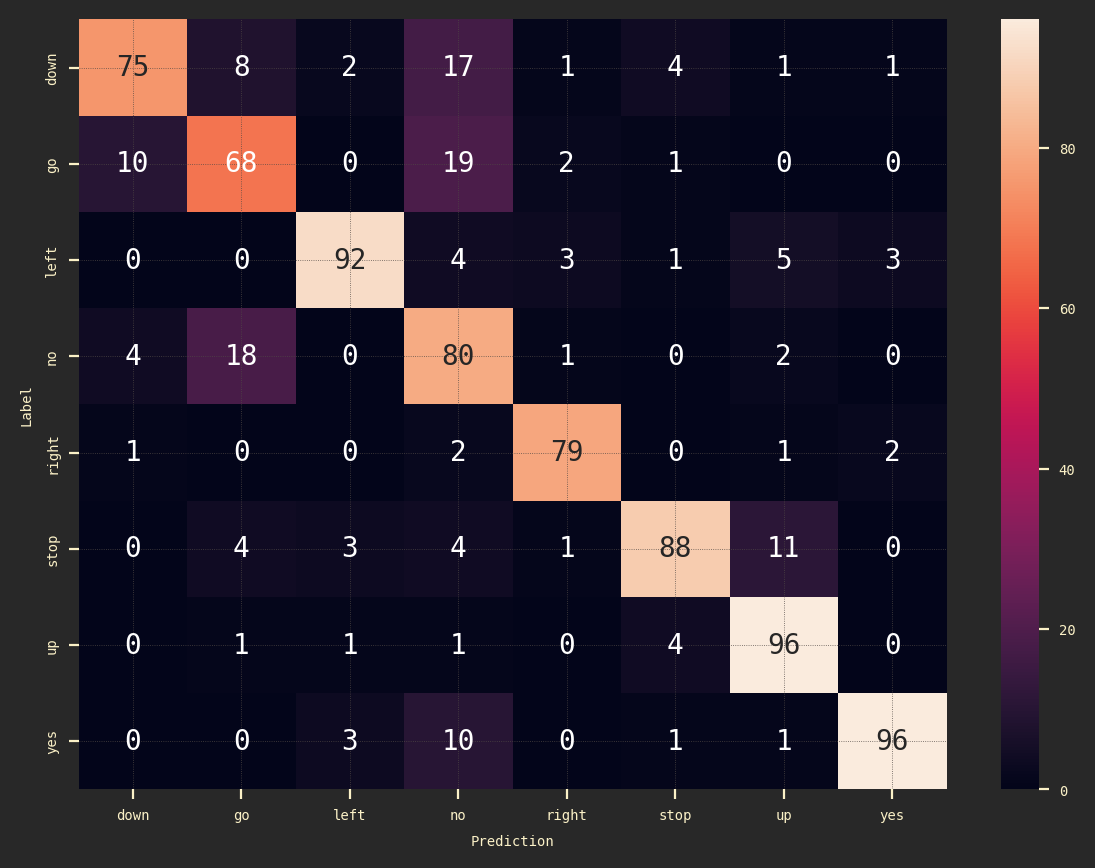

In [22]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt="g")
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

In [23]:
def predict_plot(filepath):
    x = tf.io.read_file(str(filepath))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]

    prediction = model(x)
    plt.title(label_names[np.argmax(prediction)])
    x_labels = list(label_names)
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.show()

    display.display(display.Audio(waveform, rate=16000))

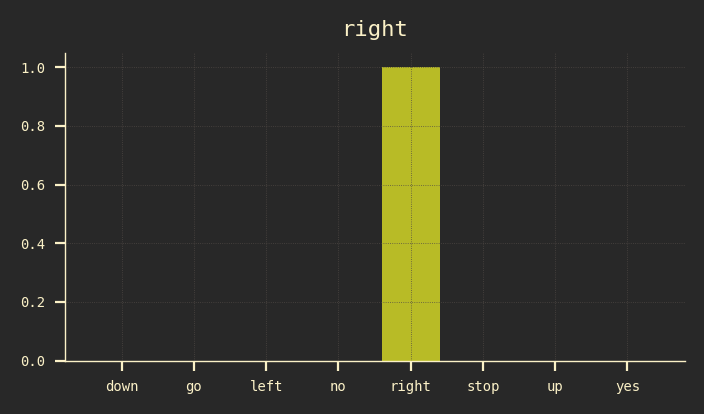

In [24]:
predict_plot(os.path.join("data/mini_speech_commands/right/0c40e715_nohash_1.wav" ))